In [1]:
from dotenv import load_dotenv
load_dotenv()


True

In [30]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def subtract(a: int, b: int) -> int:
    """Subtract a and b."""
    return a - b

# Two simple emotion tools

def add_happiness(text: str) -> str:
    """Add happiness and positivity to a given message."""
    happy_tone = [
        "That’s amazing!",
        "What a bright day ahead!",
        "Keep shining!"
    ]
    return text + " " + happy_tone[0]

def add_sadness(text: str) -> str:
    """Add a touch of sadness or empathy to a message."""
    sad_tone = [
        "That’s really unfortunate.",
        "Sometimes things just don’t go our way.",
        " I feel that pain."
    ]
    return text + " " + sad_tone[0]

tools = [add, multiply, divide,add_happiness, add_sadness]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

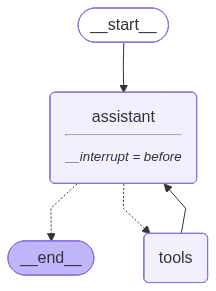

In [31]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

tools = [add, subtract]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [32]:
# Run until interruption (before assistant responds)
initial_input = {"messages": [HumanMessage(content="Add 5 and 10")]}
thread = {"configurable": {"thread_id": "basic-1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Add 5 and 10


In [33]:
# Get the current state
state = graph.get_state(thread)
print("Before edit:", state.values["messages"][-1].content)

# Manually edit the message
state.values["messages"][-1].content = "Subtract 10 from 25"
graph.update_state(thread, state.values)

# Resume the graph
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


Before edit: Add 5 and 10
================================ Human Message =================================

Subtract 10 from 25
================================== Ai Message ==================================
Tool Calls:
  subtract (call_uGbhAfysnMTXj6zlPPyp760F)
 Call ID: call_uGbhAfysnMTXj6zlPPyp760F
  Args:
    a: 25
    b: 10
================================= Tool Message =================================
Name: subtract

15


AWAITING USER INPUT

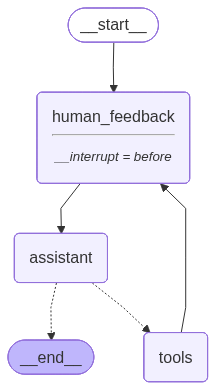

In [34]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
# Input
initial_input = {"messages": "3*(4+5)"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user input
user_input = input("Update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

3*(4+5)
================================ Human Message =================================

dos 5 + 6

================================== Ai Message ==================================
Tool Calls:
  add (call_sflzbsbdlBTA3I8ln4gzlVQE)
 Call ID: call_sflzbsbdlBTA3I8ln4gzlVQE
  Args:
    a: 4
    b: 5
  add (call_z4kkaU2n8RaS7yaR2i1MJGDz)
 Call ID: call_z4kkaU2n8RaS7yaR2i1MJGDz
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11


In [36]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================

The result of \(3 \times (4 + 5)\) is 27, because \(4 + 5 = 9\) and then \(3 \times 9 = 27\).

The result of \(5 + 6\) is 11.


EDITING GRAPH STATE IN LANGGRAPH STUDIO

In [21]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [26]:
initial_input = {"messages": "SUBTRACT 67 FROM 69"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'SUBTRACT 67 FROM 69', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'e719f2ff-b1d7-43ca-b4d7-461906b39eb2', 'example': False}
--------------------------------------------------


In [27]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'SUBTRACT 67 FROM 69',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'e719f2ff-b1d7-43ca-b4d7-461906b39eb2',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'df338d7c-a3a3-71a9-6284-b76f16db6083',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '6fce010c-8c43-4821-af4d-e5d54380e11b',
  'graph_id': 'agent',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.6.10',
  'langgraph_api_version': '0.4.39',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id':

In [28]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'SUBTRACT 67 FROM 69',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'e719f2ff-b1d7-43ca-b4d7-461906b39eb2',
 'example': False}

In [29]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'checkpoint': {'thread_id': '1002dd17-7067-4fcc-8702-9327f112d546',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3494-45d8-63dc-8001-d22ba579c991'},
 'configurable': {'thread_id': '1002dd17-7067-4fcc-8702-9327f112d546',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3494-45d8-63dc-8001-d22ba579c991'},
 'checkpoint_id': '1f0b3494-45d8-63dc-8001-d22ba579c991'}

WORKING OF THE GRAPH IN LANGGRAPH STDUIO


interrupting before the assistant
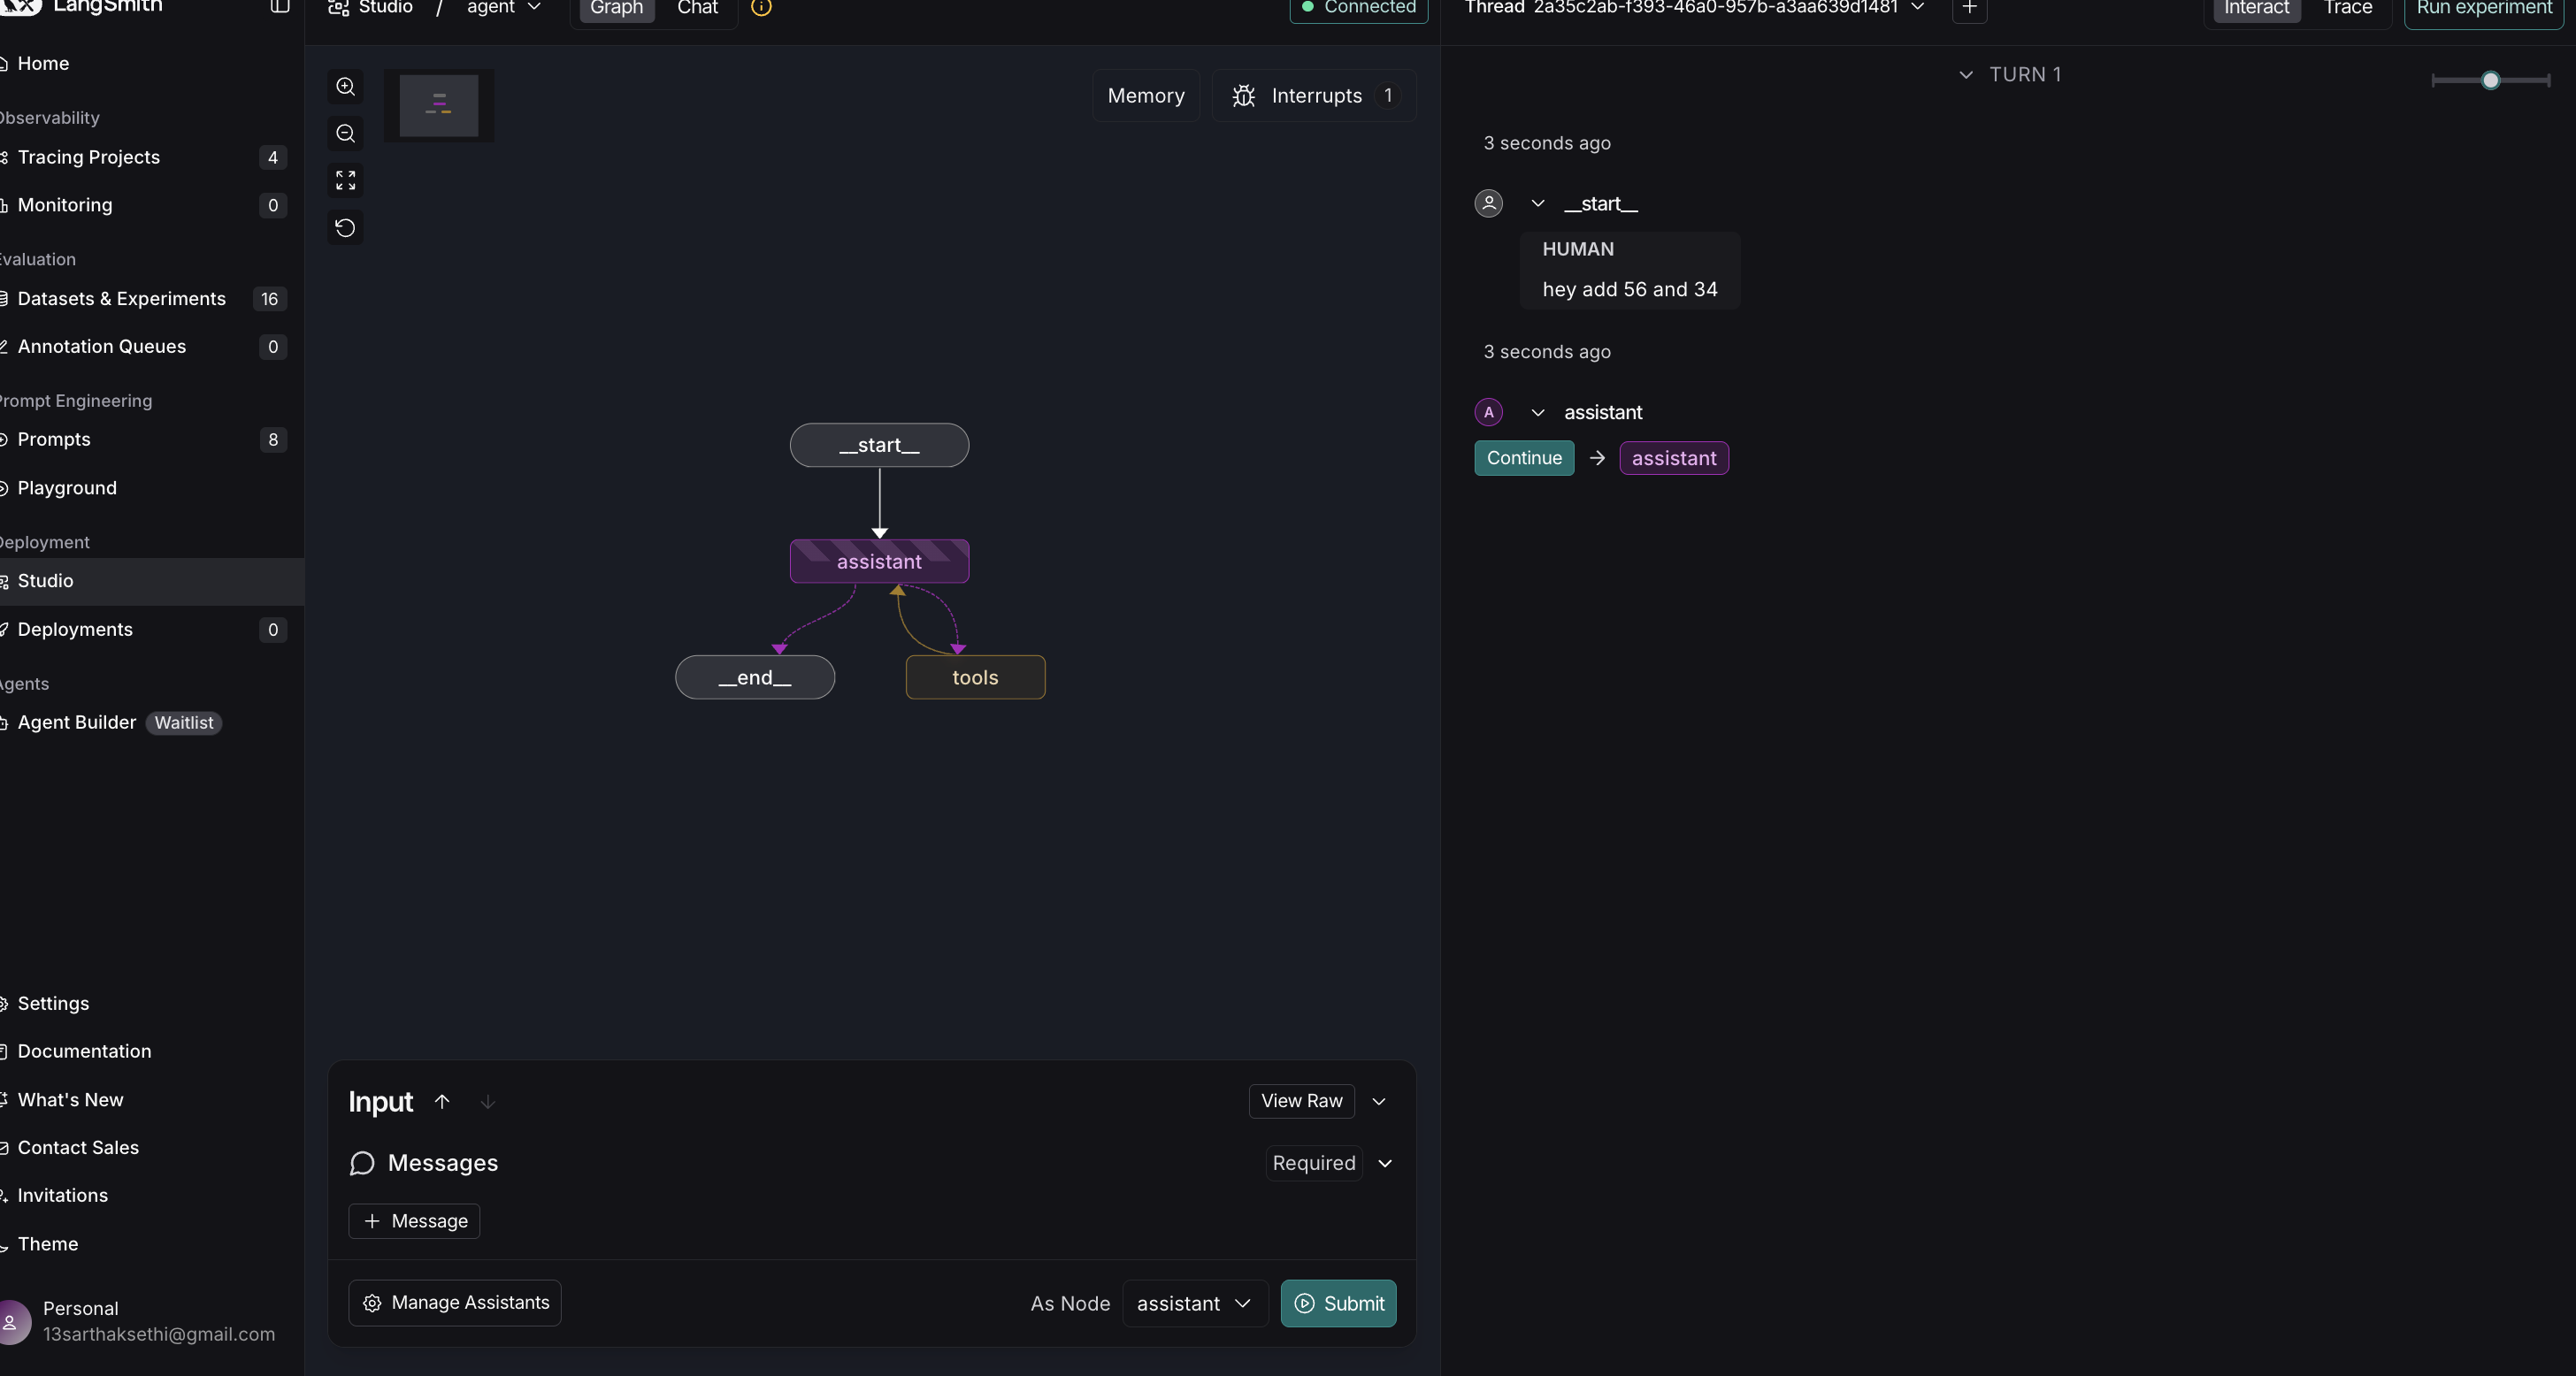

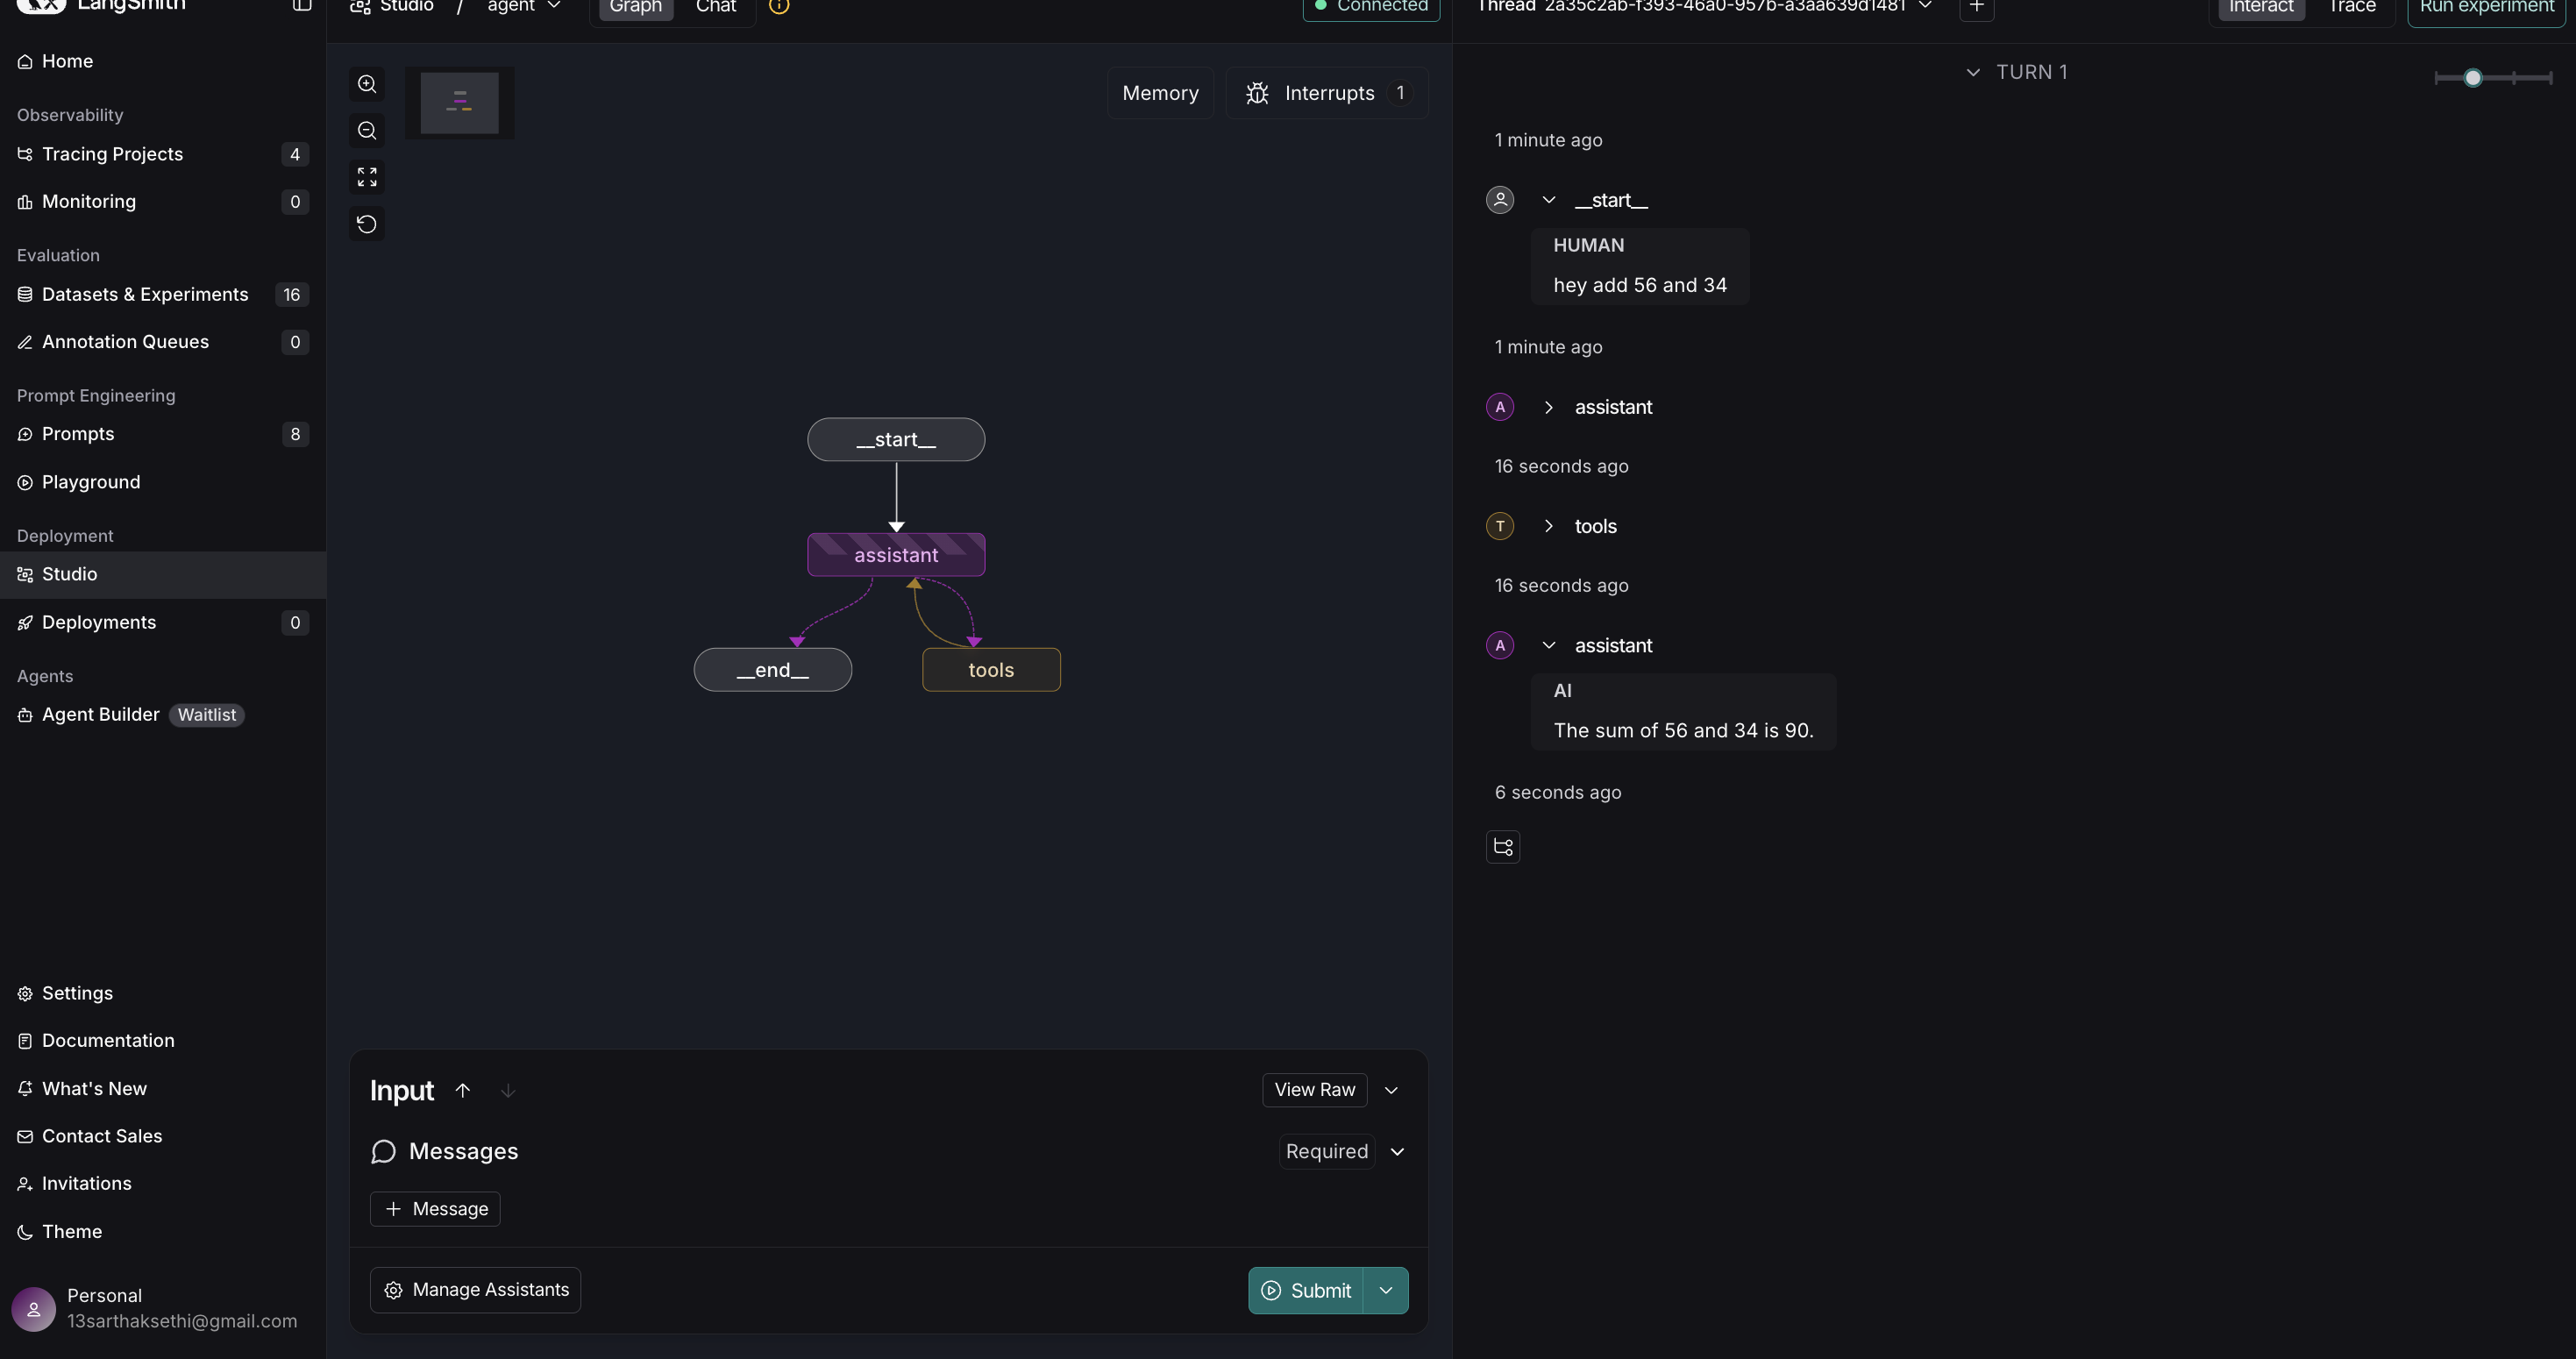
